In [1]:
!pip uninstall mlsauce --yes

In [2]:
!pip install GPopt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 3.2 MB/s eta 0:00:00


In [3]:
!pip install mlsauce

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 4.9 MB/s eta 0:00:00
  Created wheel for mlsauce: filename=mlsauce-0.8.10-cp310-cp310-linux_x86_64.whl size=3136743 sha256=fded06f7390f3fdd6f96eab1dd2a694ea04ea632a78e7855f09927b41373d2f7
  Stored in directory: /root/.cache/pip/wheels/44/e3/e1/ac4c001ea496899483d6c6d2e6e6493ffab64a6210886a1125
Successfully built mlsauce
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1


# 1 - LSBoostClassifier

In [4]:
import GPopt as gp
import mlsauce as ms
import numpy as np
from sklearn.datasets import load_breast_cancer, load_wine, load_iris, load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from time import time
from functools import cache

## 1 - 1 breast cancer

In [5]:
data = load_breast_cancer()
X = data.data
y = data.target

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=13)

In [7]:
def lsboost_cv(X_train, y_train,
               n_estimators=100,
               learning_rate=0.1,
               n_hidden_features=5,
               reg_lambda=0.1,
               dropout=0,
               tolerance=1e-4,
               seed=123):

  estimator = ms.LSBoostClassifier(n_estimators=int(n_estimators),
                                   learning_rate=learning_rate,
                                   n_hidden_features=int(n_hidden_features),
                                   reg_lambda=reg_lambda,
                                   dropout=dropout,
                                   tolerance=tolerance,
                                   seed=seed, verbose=0)

  return -cross_val_score(estimator, X_train, y_train,
                          scoring='accuracy', cv=5, n_jobs=-1).mean()


In [8]:
def optimize_lsboost(X_train, y_train):

  def crossval_objective(x):

    return lsboost_cv(
      X_train=X_train,
      y_train=y_train,
      n_estimators=int(x[0]),
      learning_rate=x[1],
      n_hidden_features=int(x[2]),
      reg_lambda=x[3],
      dropout=x[4],
      tolerance=x[5])

  gp_opt = gp.GPOpt(objective_func=crossval_objective,
                      lower_bound = np.array([10, 0.001, 5, 1e-2, 0, 0]),
                      upper_bound = np.array([100, 0.4, 250, 1e4, 0.7, 1e-1]),
                      n_init=10, n_iter=190, seed=123)
  return {'parameters': gp_opt.optimize(verbose=2, abs_tol=1e-2), 'opt_object':  gp_opt}


In [9]:
res1 = optimize_lsboost(X_train, y_train)
print(res1)
parameters = res1["parameters"]
start = time()
estimator = ms.LSBoostClassifier(n_estimators=int(parameters[0][0]),
                                   learning_rate=parameters[0][1],
                                   n_hidden_features=int(parameters[0][2]),
                                   reg_lambda=parameters[0][3],
                                   dropout=parameters[0][4],
                                   tolerance=parameters[0][5],
                                   seed=123, verbose=1).fit(X_train, y_train)


 Creating initial design... 

point: [5.500000e+01 2.005000e-01 1.275000e+02 5.000005e+03 3.500000e-01
 5.000000e-02]; score: -0.9076923076923077
point: [7.7500000e+01 1.0075000e-01 1.8875000e+02 2.5000075e+03 5.2500000e-01
 2.5000000e-02]; score: -0.9252747252747253
point: [3.2500000e+01 3.0025000e-01 6.6250000e+01 7.5000025e+03 1.7500000e-01
 7.5000000e-02]; score: -0.9010989010989011
point: [4.37500000e+01 1.50625000e-01 1.58125000e+02 1.25000875e+03
 6.12500000e-01 8.75000000e-02]; score: -0.9252747252747253
point: [8.87500000e+01 3.50125000e-01 3.56250000e+01 6.25000375e+03
 2.62500000e-01 3.75000000e-02]; score: -0.9208791208791209
point: [6.62500000e+01 5.08750000e-02 9.68750000e+01 3.75000625e+03
 8.75000000e-02 6.25000000e-02]; score: -0.8791208791208792
point: [2.12500000e+01 2.50375000e-01 2.19375000e+02 8.75000125e+03
 4.37500000e-01 1.25000000e-02]; score: -0.9032967032967033
point: [2.68750000e+01 1.25687500e-01 8.15625000e+01 6.87500313e+03
 3.93750000e-01 1.87500000e-0

  0%|          | 0/36 [00:00<?, ?it/s]

iteration 51 -----
current minimum:  [3.63891602e+01 3.71847900e-01 3.43688965e+01 2.05811341e+03
 1.69360352e-01 1.21337891e-02]
current minimum score:  -0.9516483516483516
next parameter: [9.55477905e+01 3.11368713e-02 1.75478668e+02 1.87287190e+03
 4.06375122e-01 6.46667480e-03]
score for next parameter: -0.9186813186813186 

{'parameters': (array([3.63891602e+01, 3.71847900e-01, 3.43688965e+01, 2.05811341e+03,
       1.69360352e-01, 1.21337891e-02]), -0.9516483516483516), 'opt_object': <GPopt.GPOpt.GPOpt.GPOpt object at 0x7847834fece0>}


 81%|████████  | 29/36 [00:00<00:00, 355.27it/s]


In [10]:
print(f"\n\n Test set accuracy: {estimator.score(X_test, y_test)}")
print(f"\n Elapsed: {time() - start}")



 Test set accuracy: 0.9912280701754386

 Elapsed: 0.11275959014892578


**test set accuracy's distribution**

In [11]:
from collections import namedtuple
from sklearn.metrics import classification_report
from tqdm import tqdm
from scipy import stats

In [12]:
@cache
def eval_lsboost(B=250):

  res_metric = []
  training_times = []
  testing_times = []

  DescribeResult = namedtuple('DescribeResult', ('accuracy',
                                                 'training_time',
                                                 'testing_time'))

  for i in tqdm(range(B)):

    np.random.seed(10*i+100)
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2)

    #try:
    start = time()
    obj = ms.LSBoostClassifier(n_estimators=int(parameters[0][0]),
                                   learning_rate=parameters[0][1],
                                   n_hidden_features=int(parameters[0][2]),
                                   reg_lambda=parameters[0][3],
                                   dropout=parameters[0][4],
                                   tolerance=parameters[0][5],
                                   seed=123, verbose=0).fit(X_train, y_train)
    training_times.append(time()-start)
    start = time()
    res_metric.append(obj.score(X_test, y_test))
    testing_times.append(time()-start)
    #except ValueError:
    #  continue

    res = tuple()

  return DescribeResult(res_metric, training_times, testing_times), stats.describe(res_metric), stats.describe(training_times), stats.describe(testing_times)

In [13]:
res_lsboost_B250 = eval_lsboost(B=250)

100%|██████████| 250/250 [00:11<00:00, 21.07it/s]


In [14]:
# library & dataset
import pandas as pd
import seaborn as sns
df = pd.DataFrame(res_lsboost_B250[0][0],
                  columns=["accuracy"])
print(df.head())

   accuracy
0  0.947368
1  0.982456
2  0.956140
3  0.956140
4  0.947368


<Axes: xlabel='accuracy', ylabel='Density'>

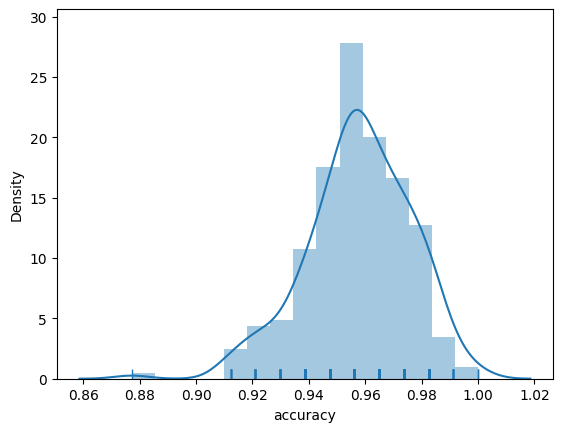

In [15]:
# Plot the histogram thanks to the distplot function
sns.distplot(a=df["accuracy"], hist=True, kde=True, rug=True)

## 1 - 2 wine

In [16]:
data = load_wine()
X = data.data
y = data.target

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=13)

In [18]:
res2 = optimize_lsboost(X_train, y_train)
print(res2)
parameters = res2["parameters"]
start = time()
estimator = ms.LSBoostClassifier(n_estimators=int(parameters[0][0]),
                                   learning_rate=parameters[0][1],
                                   n_hidden_features=int(parameters[0][2]),
                                   reg_lambda=parameters[0][3],
                                   dropout=parameters[0][4],
                                   tolerance=parameters[0][5],
                                   seed=123, verbose=1).fit(X_train, y_train)


 Creating initial design... 

point: [5.500000e+01 2.005000e-01 1.275000e+02 5.000005e+03 3.500000e-01
 5.000000e-02]; score: -0.8950738916256158
point: [7.7500000e+01 1.0075000e-01 1.8875000e+02 2.5000075e+03 5.2500000e-01
 2.5000000e-02]; score: -0.9302955665024631
point: [3.2500000e+01 3.0025000e-01 6.6250000e+01 7.5000025e+03 1.7500000e-01
 7.5000000e-02]; score: -0.8448275862068965
point: [4.37500000e+01 1.50625000e-01 1.58125000e+02 1.25000875e+03
 6.12500000e-01 8.75000000e-02]; score: -0.916256157635468
point: [8.87500000e+01 3.50125000e-01 3.56250000e+01 6.25000375e+03
 2.62500000e-01 3.75000000e-02]; score: -0.9302955665024631
point: [6.62500000e+01 5.08750000e-02 9.68750000e+01 3.75000625e+03
 8.75000000e-02 6.25000000e-02]; score: -0.6125615763546798
point: [2.12500000e+01 2.50375000e-01 2.19375000e+02 8.75000125e+03
 4.37500000e-01 1.25000000e-02]; score: -0.8312807881773399
point: [2.68750000e+01 1.25687500e-01 8.15625000e+01 6.87500313e+03
 3.93750000e-01 1.87500000e-02

 10%|█         | 9/87 [00:00<00:00, 89.68it/s]

{'parameters': (array([8.76403809e+01, 3.19294067e-01, 2.03673706e+02, 1.54175651e+03,
       3.06762695e-02, 8.17871094e-04]), -0.9790640394088671), 'opt_object': <GPopt.GPOpt.GPOpt.GPOpt object at 0x784772e73c70>}


100%|██████████| 87/87 [00:00<00:00, 137.31it/s]


In [19]:
print(f"\n\n Test set accuracy: {estimator.score(X_test, y_test)}")
print(f"\n Elapsed: {time() - start}")



 Test set accuracy: 1.0

 Elapsed: 0.6752924919128418


**test set accuracy's distribution**

In [20]:
@cache
def eval_lsboost2(B=250):

  res_metric = []
  training_times = []
  testing_times = []

  DescribeResult = namedtuple('DescribeResult', ('accuracy',
                                                 'training_time',
                                                 'testing_time'))

  for i in tqdm(range(B)):

    np.random.seed(10*i+100)
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2)

    #try:
    start = time()
    obj = ms.LSBoostClassifier(n_estimators=int(parameters[0][0]),
                                   learning_rate=parameters[0][1],
                                   n_hidden_features=int(parameters[0][2]),
                                   reg_lambda=parameters[0][3],
                                   dropout=parameters[0][4],
                                   tolerance=parameters[0][5],
                                   seed=123, verbose=0).fit(X_train, y_train)
    training_times.append(time()-start)
    start = time()
    res_metric.append(obj.score(X_test, y_test))
    testing_times.append(time()-start)
    #except ValueError:
    #  continue

    res = tuple()

  return DescribeResult(res_metric, training_times, testing_times), stats.describe(res_metric), stats.describe(training_times), stats.describe(testing_times)

In [21]:
res_lsboost2_B250 = eval_lsboost2(B=250)

100%|██████████| 250/250 [01:23<00:00,  3.01it/s]


In [22]:
# library & dataset
import pandas as pd
import seaborn as sns
df = pd.DataFrame(res_lsboost2_B250[0][0],
                  columns=["accuracy"])
print(df.head())

   accuracy
0  0.972222
1  0.861111
2  0.972222
3  0.972222
4  1.000000


<Axes: xlabel='accuracy', ylabel='Density'>

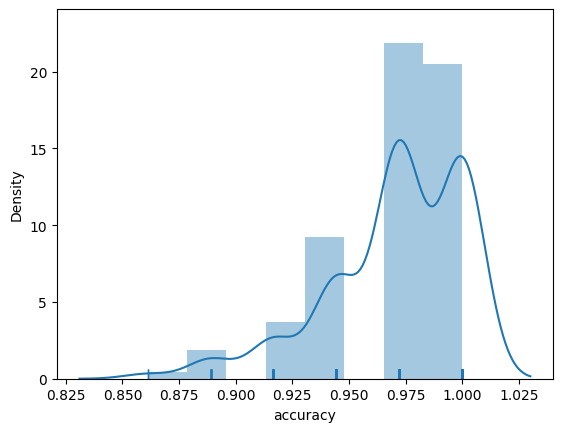

In [23]:
# Plot the histogram thanks to the distplot function
sns.distplot(a=df["accuracy"], hist=True, kde=True, rug=True)

# 2 - AdaOpt

In [24]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_val_score
from time import time


digits = load_digits()
Z = digits.data
t = digits.target
np.random.seed(13239)
X_train, X_test, y_train, y_test = train_test_split(Z, t,
                                                    test_size=0.2)

obj = ms.AdaOpt(n_iterations=50,
           learning_rate=0.3,
           reg_lambda=0.1,
           reg_alpha=0.5,
           eta=0.01,
           gamma=0.01,
           tolerance=1e-4,
           row_sample=1,
           k=1,
           n_jobs=3, type_dist="euclidean", verbose=1)
start = time()
obj.fit(X_train, y_train)
print(f"\n\n Elapsed train: {time()-start} \n")
start = time()
print(f"\n\n Accuracy: {obj.score(X_test, y_test)}")
print(f"\n Elapsed predict: {time()-start}")

100%|██████████| 360/360 [00:00<00:00, 1979.13it/s]



 Elapsed train: 0.01917862892150879 



 Accuracy: 0.9916666666666667

 Elapsed predict: 0.19308829307556152


**test set accuracy's distribution**

In [25]:
from collections import namedtuple
from sklearn.metrics import classification_report
from tqdm import tqdm
from scipy import stats

In [26]:
def eval_adaopt(k=1, B=250):

  res_metric = []
  training_times = []
  testing_times = []

  DescribeResult = namedtuple('DescribeResult', ('accuracy',
                                                 'training_time',
                                                 'testing_time'))
  obj = ms.AdaOpt(n_iterations=50,
              learning_rate=0.3,
              reg_lambda=0.1,
              reg_alpha=0.5,
              eta=0.01,
              gamma=0.01,
              tolerance=1e-4,
              row_sample=1,
              k=k,
              n_jobs=-1, type_dist="euclidean", verbose=0)

  for i in tqdm(range(B)):

    np.random.seed(10*i+100)
    X_train, X_test, y_train, y_test = train_test_split(Z, t,
                                                        test_size=0.2)

    #try:
    start = time()
    obj.fit(X_train, y_train)
    training_times.append(time()-start)
    start = time()
    res_metric.append(obj.score(X_test, y_test))
    testing_times.append(time()-start)
    #except ValueError:
    #  continue

    res = tuple()

  return DescribeResult(res_metric, training_times, testing_times), stats.describe(res_metric), stats.describe(training_times), stats.describe(testing_times)

In [27]:
res_k1_B250 = eval_adaopt(k=1, B=250)
res_k2_B250 = eval_adaopt(k=2, B=250)
res_k3_B250 = eval_adaopt(k=3, B=250)
res_k4_B250 = eval_adaopt(k=4, B=250)
res_k5_B250 = eval_adaopt(k=5, B=250)

100%|██████████| 250/250 [00:51<00:00,  4.90it/s]


In [28]:
display(res_k1_B250[1])
display(res_k2_B250[1])
display(res_k3_B250[1])
display(res_k4_B250[1])
display(res_k5_B250[1])

DescribeResult(nobs=250, minmax=(0.9722222222222222, 1.0), mean=0.9872888888888888, variance=2.5628935495066882e-05, skewness=-0.13898324248427138, kurtosis=0.22445816198359791)

DescribeResult(nobs=250, minmax=(0.9666666666666667, 0.9972222222222222), mean=0.9846888888888888, variance=3.354355694382497e-05, skewness=-0.2014633213050366, kurtosis=-0.16851847469456605)

DescribeResult(nobs=250, minmax=(0.9611111111111111, 0.9972222222222222), mean=0.9836666666666666, variance=3.45951708066838e-05, skewness=-0.3714590259216959, kurtosis=0.264762318251484)

DescribeResult(nobs=250, minmax=(0.9555555555555556, 1.0), mean=0.9793777777777778, variance=4.80023798899302e-05, skewness=-0.24910751075977636, kurtosis=0.4395617044106124)

DescribeResult(nobs=250, minmax=(0.9555555555555556, 0.9972222222222222), mean=0.9770444444444444, variance=5.1334225792057076e-05, skewness=-0.12883539300214827, kurtosis=0.1411098033435696)

In [29]:
display(res_k1_B250[2])
display(res_k2_B250[2])
display(res_k3_B250[2])
display(res_k4_B250[2])
display(res_k5_B250[2])

DescribeResult(nobs=250, minmax=(0.00498199462890625, 0.021169185638427734), mean=0.007840995788574218, variance=4.368068123193988e-06, skewness=2.175594596266775, kurtosis=7.499194342725625)

DescribeResult(nobs=250, minmax=(0.005329132080078125, 0.016299962997436523), mean=0.007670882225036621, variance=3.612048206608975e-06, skewness=1.7118375802873183, kurtosis=3.358366931595608)

DescribeResult(nobs=250, minmax=(0.0053746700286865234, 0.015506505966186523), mean=0.007794314384460449, variance=2.920214088930605e-06, skewness=1.6360801483869196, kurtosis=3.2315493234819064)

DescribeResult(nobs=250, minmax=(0.005369901657104492, 0.02190709114074707), mean=0.007874348640441894, variance=4.55353231021138e-06, skewness=2.3223174208412916, kurtosis=8.922678944294534)

DescribeResult(nobs=250, minmax=(0.005362033843994141, 0.017331361770629883), mean=0.00786894702911377, variance=4.207144846754069e-06, skewness=1.8494401442014954, kurtosis=3.8446086533270085)

In [30]:
display(res_k1_B250[3])
display(res_k2_B250[3])
display(res_k3_B250[3])
display(res_k4_B250[3])
display(res_k5_B250[3])

DescribeResult(nobs=250, minmax=(0.1675705909729004, 0.3001070022583008), mean=0.19125074195861816, variance=0.0003424395337048105, skewness=2.2500063799757677, kurtosis=5.9722526245151375)

DescribeResult(nobs=250, minmax=(0.16643667221069336, 0.31163525581359863), mean=0.1923248109817505, variance=0.0003310783018211768, skewness=2.476834016032642, kurtosis=8.109087286878708)

DescribeResult(nobs=250, minmax=(0.17519187927246094, 0.37604689598083496), mean=0.1916730365753174, variance=0.0003895799321858523, skewness=4.280046315900402, kurtosis=30.357835694940057)

DescribeResult(nobs=250, minmax=(0.17512750625610352, 0.3540067672729492), mean=0.19378959369659424, variance=0.00035161275596300016, skewness=3.595469226517824, kurtosis=21.271489103625353)

DescribeResult(nobs=250, minmax=(0.17573857307434082, 0.2584831714630127), mean=0.19390375328063963, variance=0.0002475867594812809, skewness=2.0323201018310013, kurtosis=3.343216700759352)


## 2 - 2 accuracy

In [31]:
# library & dataset
import pandas as pd
import seaborn as sns
df = pd.DataFrame(np.column_stack((res_k1_B250[0][0],
                               res_k2_B250[0][0],
                               res_k3_B250[0][0],
                               res_k4_B250[0][0])),
               columns=['k1', 'k2', 'k3', 'k4'])

<Axes: xlabel='k4', ylabel='Density'>

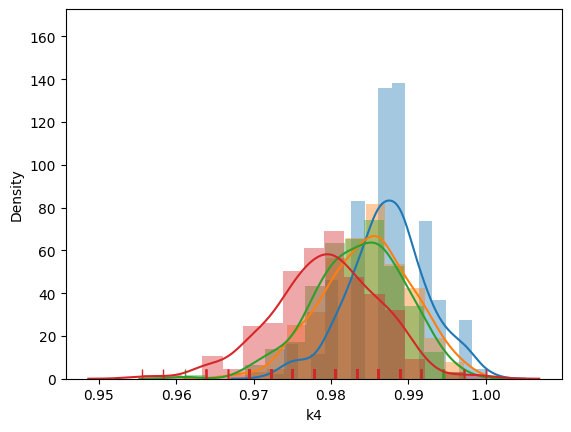

In [32]:
# Plot the histogram thanks to the distplot function
sns.distplot(a=df["k1"], hist=True, kde=True, rug=True)
sns.distplot(a=df["k2"], hist=True, kde=True, rug=True)
sns.distplot(a=df["k3"], hist=True, kde=True, rug=True)
sns.distplot(a=df["k4"], hist=True, kde=True, rug=True)

## 2 - 3 training time

<Axes: xlabel='k4', ylabel='Density'>

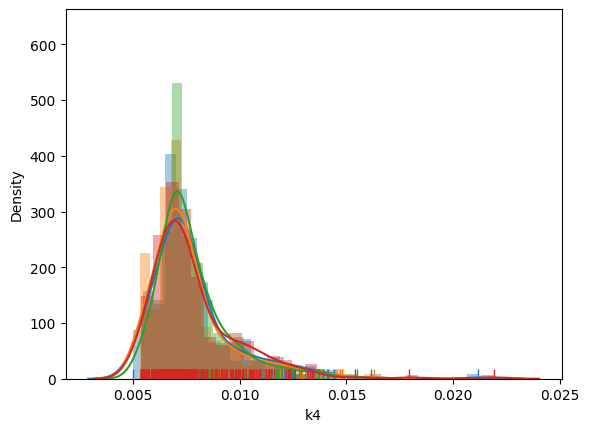

In [33]:
df = pd.DataFrame(np.column_stack((res_k1_B250[0][1],
                               res_k2_B250[0][1],
                               res_k3_B250[0][1],
                               res_k4_B250[0][1])),
               columns=['k1', 'k2', 'k3', 'k4'])
# Plot the histogram thanks to the distplot function
sns.distplot(a=df["k1"], hist=True, kde=True, rug=True)
sns.distplot(a=df["k2"], hist=True, kde=True, rug=True)
sns.distplot(a=df["k3"], hist=True, kde=True, rug=True)
sns.distplot(a=df["k4"], hist=True, kde=True, rug=True)

## 2 - 4 testing time

<Axes: xlabel='k4', ylabel='Density'>

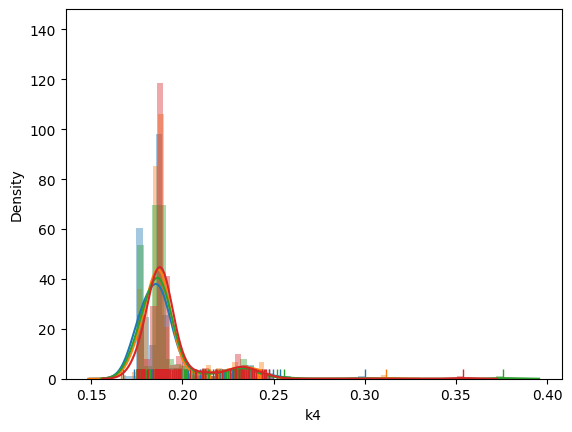

In [34]:
df = pd.DataFrame(np.column_stack((res_k1_B250[0][2],
                               res_k2_B250[0][2],
                               res_k3_B250[0][2],
                               res_k4_B250[0][2])),
               columns=['k1', 'k2', 'k3', 'k4'])
# Plot the histogram thanks to the distplot function
sns.distplot(a=df["k1"], hist=True, kde=True, rug=True)
sns.distplot(a=df["k2"], hist=True, kde=True, rug=True)
sns.distplot(a=df["k3"], hist=True, kde=True, rug=True)
sns.distplot(a=df["k4"], hist=True, kde=True, rug=True)